# Import Libraries

In [7]:
%%capture
!pip install pyDOE

In [9]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs  # Latin Hypercube Sampling
import time

# Disable TensorFlow v2 behaviors to use TensorFlow v1
tf.disable_v2_behavior()

# Set random seeds for reproducibility
np.random.seed(1234)
tf.set_random_seed(1234)

# Physics Informed Neural Network

In [15]:
class PhysicsInformedNN:
    def __init__(self, X_f, layers, V, lb, ub):
        """
        Initialize the physics-informed neural network with problem-specific parameters.

        Parameters
        ----------
        X_f : ndarray
            Training input data points generated using Latin Hypercube Sampling.
        layers : list
            List specifying the neural network architecture (number of nodes per layer).
        V : ndarray
            Potential function applied at each training point.
        lb : ndarray
            Lower boundary of the spatial domain.
        ub : ndarray
            Upper boundary of the spatial domain.
        """
        self.lb, self.ub = lb, ub
        self.x_f = X_f[:, 0:1]
        self.V = V
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        self.g = 100  # Interaction strength

        # Inputs and potential
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.V_tf = tf.placeholder(tf.float32, shape=[None, self.V.shape[1]])

        # Boundary conditions
        self.lb_tf = tf.constant(lb.reshape(1, -1), dtype=tf.float32)  # Left boundary
        self.ub_tf = tf.constant(ub.reshape(1, -1), dtype=tf.float32)  # Right boundary

        # Predicted values and PDE residuals
        self.u0_pred, u_x, self.uv_max = self.net_uv(self.x_f_tf)
        u_xx = tf.gradients(u_x, self.x_f_tf)[0]

        # Riesz energy loss
        # energy_loss = (tf.reduce_mean(tf.square(u_x)) +
        #                tf.reduce_mean(self.V_tf * tf.square(self.u0_pred)) +
        #                (self.g / 2) * tf.reduce_mean(tf.square(self.u0_pred) ** 2))

        # Riesz energy loss
        kinetic_term = tf.reduce_mean(tf.square(u_x))
        potential_term = tf.reduce_mean(self.V_tf * tf.square(self.u0_pred))
        interaction_term = 0.5 * self.g * tf.reduce_mean(tf.square(self.u0_pred) ** 2)
        energy_loss = 0.5 * (kinetic_term + potential_term + interaction_term)

        # Boundary loss to enforce Dirichlet conditions at x = lb and x = ub
        boundary_loss = self.boundary_loss()

        # PDE loss including regularization terms
        pde_loss, _, _ = self.pde_loss(self.x_f_tf, self.u0_pred)

        # L^2 norm constraint: Penalizes deviation from norm = 1
        l2_norm = tf.sqrt(tf.reduce_mean(tf.square(self.u0_pred)))
        l2_norm_loss = tf.square(l2_norm - 1)  # Squared difference from 1

        # Total loss combining energy, boundary, PDE, and L^2 norm constraint
        self.loss = boundary_loss + energy_loss + pde_loss #+ 10 * l2_norm_loss   # pde_loss / self.uv_max?

        # Optimizer
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=1e-3)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        # Initialize TensorFlow session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
        self.sess.run(tf.global_variables_initializer())

    def boundary_loss(self):
        """
        Compute the boundary loss to enforce Dirichlet boundary conditions.

        Returns
        -------
        tf.Tensor
            Mean squared error loss at the boundaries to enforce u(lb) = 0 and u(ub) = 0.
        """
        u_lb_pred = self.net_uv(self.lb_tf)[0]
        u_ub_pred = self.net_uv(self.ub_tf)[0]
        return tf.reduce_mean(tf.square(u_lb_pred)) + tf.reduce_mean(tf.square(u_ub_pred))

    def pde_loss(self, x, u):
        """
        Compute the PDE loss for the 1D Gross-Pitaevskii equation with regularization terms.

        Parameters
        ----------
        x : tf.Tensor
            Input tensor for spatial points.
        u : tf.Tensor
            Predicted solution at spatial points.

        Returns
        -------
        tuple
            A tuple containing the PDE loss, PDE residual, and smallest eigenvalue (lambda).
        """
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]

        # Compute lambda_pde as the average energy value
        lambda_pde = tf.reduce_mean(u_x ** 2 + self.V_tf * u ** 2 + self.g * u ** 4) / tf.reduce_mean(u ** 2)

        # Gross-Pitaevskii equation residual
        pde_residual = -u_xx + self.V_tf * u + self.g * tf.math.abs(u ** 2) * u - (lambda_pde * u)

        # Regularization terms
        target_mean_u_squared = 1e-4
        L_f = tf.maximum(1 / (tf.reduce_mean(tf.square(u)) + 1e-2), target_mean_u_squared)
        min_lambda = 1e-4
        L_lambda = tf.maximum(1 / (tf.square(lambda_pde) + 1e-6), min_lambda)
        L_drive = tf.maximum(tf.exp(-lambda_pde + min_lambda), 0.5)

        # pde_loss = tf.reduce_mean(tf.square(pde_residual)) + L_lambda + L_f + L_drive
        pde_loss = tf.reduce_mean(tf.square(pde_residual))
        return pde_loss, pde_residual, lambda_pde

    def initialize_NN(self, layers):
        """
        Initialize the neural network weights and biases using Xavier initialization.

        Parameters
        ----------
        layers : list
            List specifying the neural network architecture (number of nodes per layer).

        Returns
        -------
        tuple
            A tuple containing lists of initialized weights and biases for each layer.
        """
        weights, biases = [], []
        for l in range(len(layers) - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        """
        Xavier initialization for the neural network layers.

        Parameters
        ----------
        size : list
            List of two integers specifying the input and output dimensions of the layer.

        Returns
        -------
        tf.Variable
            Initialized weights for the layer.
        """
        in_dim, out_dim = size[0], size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        """
        Forward pass through the neural network.

        Parameters
        ----------
        X : tf.Tensor
            Input data tensor.
        weights : list
            List of weights for each layer.
        biases : list
            List of biases for each layer.

        Returns
        -------
        tf.Tensor
            Output of the neural network.
        """
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for W, b in zip(weights[:-1], biases[:-1]):
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        return tf.add(tf.matmul(H, weights[-1]), biases[-1])

    def net_uv(self, x):
        """
        Predict the solution and compute derivatives for the physics-informed loss.

        Parameters
        ----------
        x : tf.Tensor
            Input tensor for spatial points.

        Returns
        -------
        tuple
            A tuple containing the solution, its gradient, and the maximum absolute value.
        """
        uv = self.neural_net(x, self.weights, self.biases)
        u = uv[:, 0:1]
        u_max = tf.reduce_max(tf.abs(u))
        u_x = tf.gradients(u, x)[0]
        return u, u_x, u_max

    def train(self, nIter):
        """
        Train the neural network using the Adam optimizer.

        Parameters
        ----------
        nIter : int
            Number of training iterations.
        """
        tf_dict = {self.x_f_tf: self.x_f, self.V_tf: self.V}
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            if it % 500 == 0:
                loss_value = self.sess.run(self.loss, tf_dict).item()
                print(f'Iteration: {it}, Loss: {loss_value:.3e}')

    def predict(self, X_star):
        """
        Predict the solution at new spatial points.

        Parameters
        ----------
        X_star : ndarray
            Array of spatial points where prediction is required.

        Returns
        -------
        ndarray
            Predicted solution values.
        """
        tf_dict = {self.x_f_tf: X_star}
        return self.sess.run(self.u0_pred, tf_dict)

# Plot Results

In [11]:
def plot_results(x_star, u_pred):
    """
    Plot the predicted solution.

    Parameters
    ----------
    x_star : ndarray
        Array of spatial points.
    u_pred : ndarray
        Predicted solution values at the spatial points.
    """
    x_star = x_star.flatten()
    u_pred = u_pred.flatten()

    plt.figure(figsize=(8, 6))
    plt.plot(x_star, u_pred, label="Predicted Solution")
    plt.xlabel("x")
    plt.ylabel("u_pred")
    plt.title("Predicted Solution in 1D")
    plt.legend()
    plt.show()

# Plot Potential

In [12]:
def plot_potential(x, V):
    """
    Plot the potential function.

    Parameters
    ----------
    x : ndarray
        Array of spatial points.
    V : ndarray
        Potential values at the spatial points.
    """
    x = x.flatten()
    V = V.flatten()

    plt.figure(figsize=(8, 6))
    plt.plot(x, V, label="Potential V(x)", color="orange", linestyle="-", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("V(x)")
    plt.title("Potential Function V(x) along 1D Interval")
    plt.legend()
    plt.show()

# Main

In [16]:
lb, ub = np.array([-12.0]), np.array([12.0])
N_f, layers = 5000, [1, 200, 200, 200, 1]
x = np.linspace(-12.0, 12.0, 256).flatten()[:, None]
X_f = lb + (ub - lb) * lhs(1, N_f)

V0 = 1.0
x0 = np.pi / 2
sigma = 0.5
V = V0 * np.exp(-((X_f[:, 0:1] - x0) ** 2) / (2 * sigma ** 2))

nn = PhysicsInformedNN(X_f, layers, V, lb, ub)
nn.train(nIter=5000)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Iteration: 0, Loss: 5.399e-01
Iteration: 500, Loss: 2.963e-13
Iteration: 1000, Loss: 2.964e-13
Iteration: 1500, Loss: 2.965e-13
Iteration: 2000, Loss: 2.969e-13
Iteration: 2500, Loss: 2.968e-13
Iteration: 3000, Loss: 2.966e-13
Iteration: 3500, Loss: 2.962e-13
Iteration: 4000, Loss: 2.960e-13
Iteration: 4500, Loss: 2.962e-13


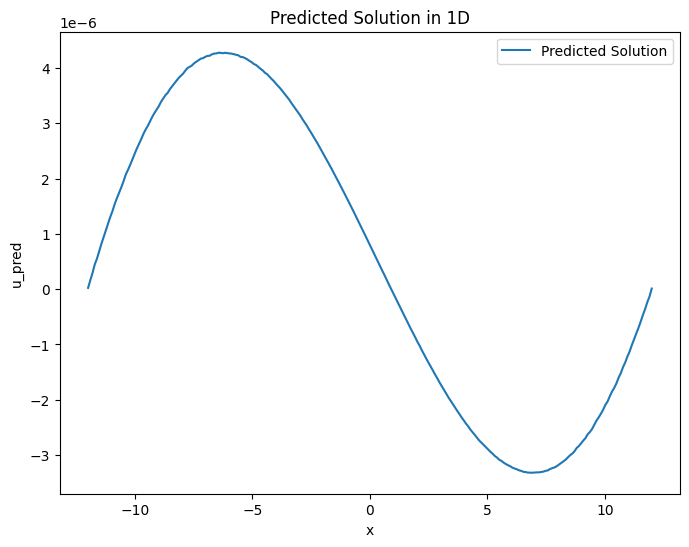

In [17]:
u_pred = nn.predict(x)
plot_results(x, u_pred)